In [111]:
import json
import pandas as pd
import numpy as np

import os
import datetime
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, InputLayer, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

from keras.initializers import glorot_normal

import math
from keras.datasets import cifar100
from scipy.cluster.vq import whiten

import glob

%matplotlib inline

<font color="red">CUt out images instead of spreading them </font>

In [112]:
def load_image(filename, img_rows=100, img_cols=100, plot=True):
    try:
        # load an image in PIL format
        original = load_img(filename, target_size=(img_rows, img_cols))

        # convert the PIL image to a numpy array
        # IN PIL - image is in (width, height, channel)
        # In Numpy - image is in (height, width, channel)
        numpy_image = img_to_array(original)

        # Convert the image / images into batch format
        # expand_dims will add an extra dimension to the data at a particular axis
        # We want the input matrix to the network to be of the form (batchsize, height, width, channels)
        # Thus we add the extra dimension to the axis 0.
        image_batch = np.expand_dims(numpy_image, axis=0)
        if plot: plt.imshow(np.uint8(image_batch[0]))
        return image_batch
    except IOError:
        # image_list.remove(filename)
        print("removed")
        return np.array([])

In [113]:
def fetch_data (file_path, img_rows=100, img_cols=100, cutoff=-1):
    # 2. Auto-iterate using the query syntax
    #    https://developers.google.com/drive/v2/web/search-parameters
    
    # file_list = glob.glob("./data/input/" + file_path + "/*.JPEG")
    file_list = glob.glob(file_path + "/*.JPEG")
  
    final_images = []
    batches = []
    for f in file_list[0:cutoff]:
        curr_image = load_image(f, img_rows, img_cols)
        if curr_image.size != 0:
            final_images.append(f)
            batches.append(curr_image)
    batches = [b[0] for b in batches]
    return final_images, np.array(batches)

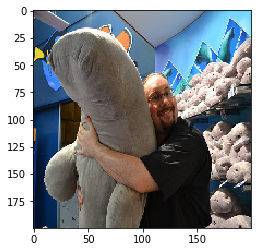

In [114]:
img_rows, img_cols = 200, 200
input_path = "351_Data\\ILSVRC2012_Validation\\"
final_images, batches = fetch_data(input_path + "images", img_rows, img_cols, 2000)

In [115]:
image_ids = [int(f.split("_")[-1].split(".JPEG")[0]) - 1 for f in final_images]

In [117]:
labels = np.array(pd.read_csv("351_Data\ILSVRC2012_Validation\labels\ILSVRC2012_devkit_t12\data\ILSVRC2012_validation_ground_truth.txt", header=None, names=["Class"]))

In [118]:
curr_labels = labels [image_ids]

In [119]:
curr_labels

array([[490],
       [361],
       [171],
       ..., 
       [679],
       [969],
       [193]], dtype=int64)

# Neural network test

In [120]:
x_train, x_test, y_train, y_test = train_test_split(batches, curr_labels, test_size=0.25)

In [121]:
def format_data(x_train, x_test):
    x_train = x_train.astype('float32')/255.
    x_test = x_test.astype('float32')/255.
    return x_train, x_test

In [122]:
x_train, x_test = format_data(x_train, x_test)

Does Whitening work when it is done independently on x_train and x_test? (e.g., should the same whitening factor be used on x_test as on x_train)

In [123]:
def filter_for_classes(X, y, classes):
    mask = np.isin(y, classes)
    mask = mask.reshape(len(mask))
    return X[mask], y[mask]

In [124]:
classes_to_retain = range(0,1000)
num_classes = len(classes_to_retain)
x_train, y_train = filter_for_classes(x_train, y_train, classes_to_retain)
x_test, y_test = filter_for_classes(x_test,y_test,classes_to_retain)

In [125]:
x_train.shape

(1499, 200, 200, 3)

In [126]:
def whiten_data(x_train, x_test):
    X = np.append(x_train, x_test, axis=0)
    X_white = whiten(X).reshape(X.shape)
    x_train_white = X_white[0:x_train.shape[0]]
    x_test_white = X_white[x_train.shape[0]:x_train.shape[0]+x_test.shape[0]]
    return x_train_white, x_test_white

In [127]:
x_train, x_test = whiten_data(x_train,x_test)

I actually think most of the reshaping above is unnecessary because we actually need a 50000, 3\*32\*32 shape

In [128]:
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)
# y_val_categorical = to_categorical(y_val)

In [129]:
datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0.0, width_shift_range=0.0, height_shift_range=0.0, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None)


In [130]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)

## Model Definition

I will start by "randomly" creating models.

In [131]:
from keras.applications import InceptionV3, Xception, InceptionResNetV2
from keras import Model
models = []
input_shape = x_train[0].shape

In [132]:
incpv3_model = InceptionV3(include_top=True, input_shape=input_shape)
models.append(incpv3_model)

In [140]:
xcep_model = Xception(input_shape=input_shape)
models.append(xcep_model)

91889664/91884032 [==============================] - 68s 1us/step


In [141]:
incepresnet_model = InceptionResNetV2(input_shape=input_shape)
models.append(incepresnet_model)

225214464/225209952 [==============================] - 146s 1us/step


In [142]:
lr = 0.001
for model in models:
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=lr),
              metrics=['accuracy'])

In [144]:
for model in models:  
    model.fit_generator(datagen.flow(x_train, y_train_categorical,
          batch_size=20),
          steps_per_epoch = len(x_train)/20,
          epochs=1,
          verbose=1,)
    print ("Model success")

Epoch 1/1
40/74 [===============>..............] - ETA: 13:30 - loss: 6.7777 - acc: 0.0201

KeyboardInterrupt: 

In [137]:
for model in models:
    score = model.evaluate(x_train, y_train_categorical, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

Test loss: 13.5520093427
Test accuracy: 0.00200133422282


In [147]:
now = datetime.datetime.now()
prefix = now.strftime("%Y%m%d_%H%M")

In [149]:
def cut_model (input_model):
    dense_layer_count = 0
    count = False
    model_length = len(input_model.layers)
    output_model = Sequential()
    output_config = []
    for index in range(model_length):
        if (count == True):
            output_config.append(layer.get_config())
            input_model.pop()
        else: layer = input_model.layers[index]
        if layer.name.startswith('flatten'):
            count = True
            output_model.add(InputLayer(input_shape=layer.output_shape))          

        print (output_config)
        # return output_model

In [151]:
# output_models = []
for model in models:
    cut_model(model)
    # output_models.append(out)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

In [145]:
def create_output_files ():
    for model_ind, model in enumerate(models):
        
        pred_train = model.predict(x_train)
        pred_test = model.predict(x_test)
        pred_train_with_target = np.array([np.append(preds[i], y_train[i]) for preds,i in enumerate(pred_train)])
        pred_test_with_target = np.array([np.append(preds[i], y_test[i]) for preds,i in enumerate(pred_test)])
        
        path = input_path + "Intermediate\\" + prefix
        np.save(path + "\\train", pred_train_with_target)
        np.save(path + "\\test", pred_test_with_target)

In [ ]:
for model_ind, model in enumerate(models):
        create_output_file(folder_id, model.to_json(), "image_model_{}_cut.json".format(model_ind), drive)
        create_output_file(folder_id, np.array2string(np.array(model.weights)), "image_model_{}_cut_weights.txt".format(model_ind), drive)

        f_name = "{}_pred_train_with_target_cut_data.npy".format(model_ind)
        np.save(f_name, pred_train_with_target)
        uploaded = drive.CreateFile({'title': f_name, "parents":  [{"id": folder_id}]})
        uploaded.SetContentFile(f_name)
        uploaded.Upload()
        print('Uploaded file with ID {}'.format(uploaded.get('id')))
        f_name = "{}_pred_val_with_target_cut_data.npy".format(model_ind)
        np.save(f_name, model["pred_val_with_target"])
        uploaded = drive.CreateFile({'title': f_name, "parents":  [{"id": folder_id}]})
        uploaded.SetContentFile(f_name)
        uploaded.Upload()
        print('Uploaded file with ID {}'.format(uploaded.get('id')))

        f_name = "{}_pred_test_with_target_cut_data.npy".format(model_ind)
        np.save(f_name, model["pred_test_with_target"])
        uploaded = drive.CreateFile({'title': f_name, "parents":  [{"id": folder_id}]})
        uploaded.SetContentFile(f_name)
        uploaded.Upload()
        print('Uploaded file with ID {}'.format(uploaded.get('id')))
    
    
    
 

In [146]:
print(prefix)

NameError: name 'prefix' is not defined

In [137]:
create_output_separate_train_val()

Uploaded file with ID 1F1ON2APyRZBtLpxPHsAYk6hzkucXmz4y
Uploaded file with ID 19rYJTNXE1FslLCIXOqimtA9aK9Sd-Qn1
Uploaded file with ID 19mAucp15sh2x59K2ujxSpi91JnBOwobb
